Importing the Library 

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Changing the image color as to pre process it easily

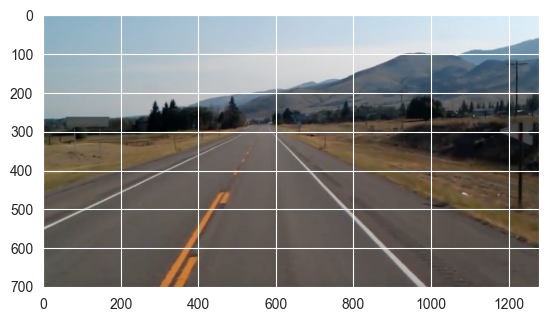

In [3]:
image =cv2.cvtColor(cv2.imread("test_image.jpg"), cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

Extracting Dimension of Image 

In [4]:
import numpy as np

lane_image = np.copy(image)
lane_image.shape

(704, 1279, 3)

Preprocessing of image

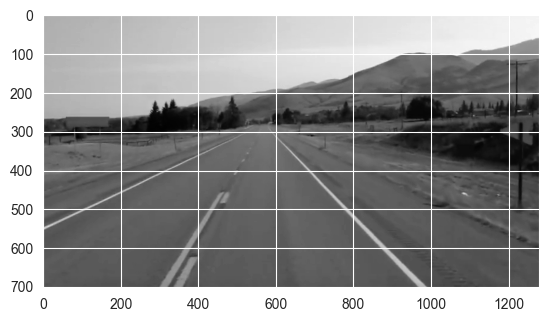

In [5]:
gray = cv2.cvtColor(lane_image, cv2.COLOR_RGB2GRAY)

plt.imshow(gray,cmap='gray')
plt.show()

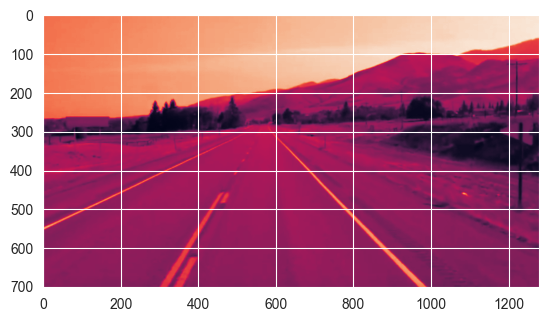

In [6]:
blur = cv2.GaussianBlur(gray, (5,5), 0)

plt.imshow(blur)
plt.show()

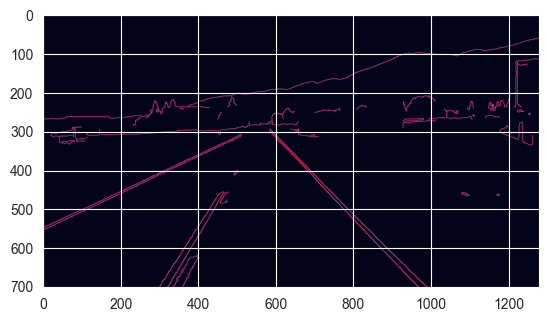

In [7]:
canny = cv2.Canny(blur, 50,150)

plt.imshow(canny)
plt.show()

Detecting the edges of the road

In [8]:
def Canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    canny = cv2.Canny(blur, 50, 150)

    return canny

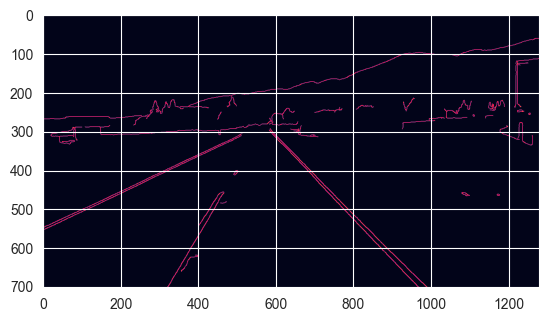

In [9]:
image = cv2.imread("test_image.jpg")
lane_image = np.copy(image)
canny = Canny(lane_image)

plt.imshow(canny)
plt.show()

In [10]:
def region_of_interest(image):
    height = 700
    polygons = np.array([[(250,height), (1000,height), (600,250)]])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255)
    masked_region = cv2.bitwise_and(image, mask)

    return masked_region

In [11]:
def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            if line is not None and len(line) == 4:
                x1, y1, x2, y2 = line
                cv2.line(line_image, (x1,y1), (x2,y2), (255,0,0), 10)
    return line_image

Training the Model

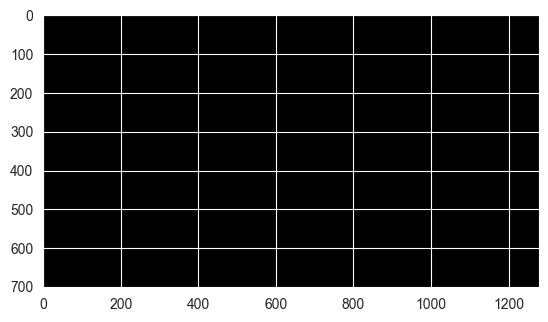

In [12]:
image = cv2.imread("test_image.jpg")

lane_image = np.copy(image)
canny_image = Canny(lane_image)
cropped_image = region_of_interest(canny_image)

lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), 40, 5)
line_image = display_lines(lane_image, lines)

plt.imshow(line_image)
plt.show()

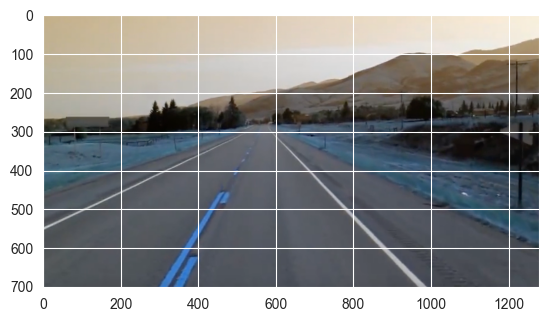

In [13]:
combo_image = cv2.addWeighted(lane_image, 1, line_image, 1, 1)

plt.imshow(combo_image)
plt.show()

In [14]:
def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(3/5))
    x1 = int((y1-intercept)/slope)
    x2 = int((y2-intercept)/slope)
    return np.array([x1,y1,x2,y2])

In [15]:
def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1,x2), (y1,y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    left_line = right_line = None
    if left_fit:
        left_fit_average = np.average(left_fit, axis=0)
        left_line = make_coordinates(image, left_fit_average)
    if right_fit:
        right_fit_average = np.average(right_fit, axis=0)
        right_line = make_coordinates(image, right_fit_average)
    return left_line, right_line

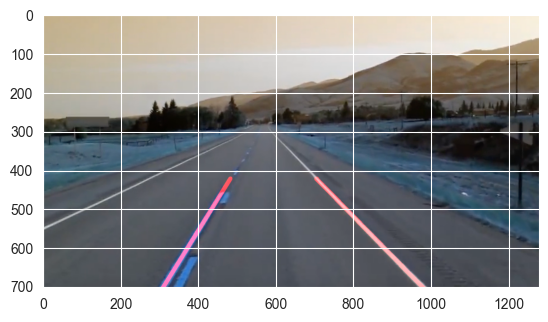

In [24]:
image = cv2.imread("test_image.jpg")

lane_image = np.copy(image)
canny_image = Canny(lane_image)
cropped_image = region_of_interest(canny_image)

lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), 40, 5)
averaged_lines = average_slope_intercept(lane_image, lines)
line_image = display_lines(lane_image, averaged_lines)

# final step: put it all together
# now combine the above immage containing just the lines in a black image with our original image

combo_image = cv2.addWeighted(lane_image, 1, line_image, 1, 1)

plt.imshow(combo_image)
plt.show()

testing the model 

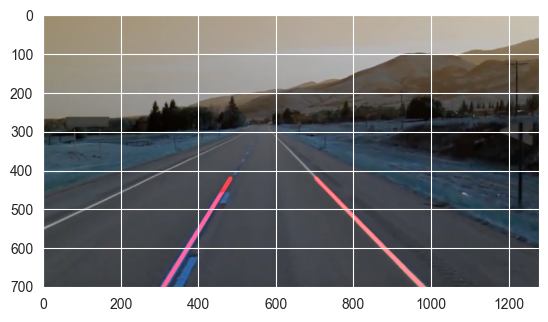

The text file is saved at: E:\machine learning\road detection\bounding_boxes_road.txt


In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(3/5))
    x1 = int((y1-intercept)/slope)
    x2 = int((y2-intercept)/slope)
    return np.array([x1,y1,x2,y2])

def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1,x2), (y1,y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    left_fit_average = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0)
    left_line = make_coordinates(image, left_fit_average)
    right_line = make_coordinates(image, right_fit_average)
    return np.array([left_line, right_line])

def Canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    canny = cv2.Canny(blur, 50, 150)
    return canny

def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return line_image

def region_of_interest(image):
    height = image.shape[0]
    polygons = np.array([
        [(200, height), (1100, height), (550, 250)]
    ])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

def write_bounding_boxes_to_file(lines, file_path):
    with open(file_path, 'w') as f:
        for line in lines:
            x1, y1, x2, y2 = line
            # Calculate bounding box
            min_x = min(x1, x2)
            max_x = max(x1, x2)
            min_y = min(y1, y2)
            max_y = max(y1, y2)
            # Write bounding box to file
            f.write(f"{min_x},{min_y},{max_x},{max_y}\n")

# Replace this with the path to your image or video file
image_file = 'test_image.jpg'

image = cv2.imread(image_file)
lane_image = np.copy(image)
canny_image = Canny(lane_image)
cropped_image = region_of_interest(canny_image)
lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
averaged_lines = average_slope_intercept(lane_image, lines)
line_image = display_lines(lane_image, averaged_lines)
combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1)
averaged_lines = average_slope_intercept(lane_image, lines)
line_image = display_lines(lane_image, averaged_lines)
combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1)

# Write bounding boxes to file
write_bounding_boxes_to_file(averaged_lines, 'bounding_boxes_road.txt')

plt.imshow(combo_image)
plt.show()

import os

# Get the current working directory
cwd = os.getcwd()

# Create the absolute file path
file_path = os.path.join(cwd, 'bounding_boxes_road.txt')

print(f"The text file is saved at: {file_path}")


Testing the model to detect road using a video file

In [5]:
def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1,x2), (y1,y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    left_line = right_line = None
    if left_fit:
        left_fit_average = np.average(left_fit, axis=0)
        left_line = make_coordinates(image, left_fit_average)
    if right_fit:
        right_fit_average = np.average(right_fit, axis=0)
        right_line = make_coordinates(image, right_fit_average)
    return left_line, right_line

cap = cv2.VideoCapture("test_video.mp4")
while (cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break
    canny_image = Canny(frame)
    cropped_image = region_of_interest(canny_image)
    lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
    averaged_lines = average_slope_intercept(frame, lines)
    line_image = display_lines(frame, averaged_lines)
    combo_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
    cv2.imshow("result", combo_image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined